# Implementación 
### Equipo: 

In [1]:
# Parámetros generales del notebook
ruta_bases = '/Users/fernando/Documents/bases/'
sample_size = 500

In [2]:
# Importación de librerías
import json
import glob
import pandas as pd
import numpy as np
import missingno as msgno
import matplotlib.pyplot as plt
import funciones as fn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from ml_classes import PrepML, MLModel
from matplotlib.pyplot import rcParams
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from lib.get_nhtsa_json import get_nhtsa_json

In [3]:
# Parámetros generales para plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8
# Semilla pseudo-aleatoria
rd_seed = 1234

# 0. Obtener la información

Esta es una demostración del proceso realizado por `get_features.py` para poder obtener información relacionada con el `Vin` de los vehículos a través de una API. El proceso consite en los siguientes pasos:
* 1.- Extraer todos los `Vin` de la base completa `true_car_listings.csv`.
* 2.- Requerir a través de la Api 'chunks' de 50 registros por cada petición.
* 3.- Guardar en la memoria el json en formato texto, agregando 50 registros por cada iteración.
* 4.- Una vez completada las iteraciones guardar en formato json todos los registros requeridos.

In [4]:
# Requerimos todos los 'Vin'    
all_vins = pd.read_csv(f'{ruta_bases}true_car_listings.csv')['Vin'].to_list()
# Parámetros de muestra
start = 10
end = 12

json_text = '['
for i in range(start, end+1):
    # Generar requerimiento con 50 registros Vin
    vin_list = all_vins[50 * (i - 1):50 * i]
    json_text += get_nhtsa_json(vin_list, i)

# Cerrar lista de Json
json_text = json_text[:-2] + ']'
# Exportar resultados a archivo json
with open(f'api_test/data_{start}_{end}.json', 'w') as json_file:
    json_file.write(json_text)

10: 2.7s
11: 2.4s
12: 2.4s


Paralelamente, en base a una muestra de la base total, se definió el primer filtro de variables requeridas a través la API: que tengan menos del 10% de datos perdidos, las cuales se presentan a continaución:

In [5]:
cols = ['AirBagLocFront', 'BodyClass', 'BusFloorConfigType', 'BusType',
       'CustomMotorcycleType', 'DisplacementCC', 'DisplacementCI',
       'DisplacementL', 'Doors', 'EngineCylinders', 'EngineHP', 'EngineKW',
       'ErrorCode', 'ErrorText', 'FuelTypePrimary', 'Make', 'Manufacturer',
       'ManufacturerId', 'Model', 'ModelYear', 'MotorcycleChassisType',
       'MotorcycleSuspensionType', 'PlantCity', 'PlantCountry', 'TPMS',
       'TrailerBodyType', 'TrailerType', 'VIN', 'VehicleType']

Con estas columnas seleccionadas, se procede a importar los archivos json (varios en el proceso original) para luego mapearlos para retraer solo aquellas columnas, creando un DataFrame con ellas y luego exportarlas en un csv.

In [6]:
# Importación de archivo json
filenames = glob.glob('api_test/*.json')
json_list = []

for filename in filenames:
    print(filename)
    with open(filename, 'r') as file:
        # Mapeamos considerando solo las columnas seleccionadas
        data = list(map(fn.get_info, 
                        json.loads(file.read())
                       )
                   )
    json_list += data

# Creación y exortación de DataFrame con features extraídos
data_json = pd.DataFrame(data=json_list,
                         columns=cols)
data_json.to_csv('api_test/data_api.csv')

api_test/data_10_12.json


# 1. Creación del Dataset 

## 1.1 Bases Originales

In [7]:
# Importación de las bases para muestras de entrenamiento y prueba
df_train = pd.read_csv(f'{ruta_bases}true_cars_train.csv',
                       delimiter=";")
df_test = pd.read_csv(f'{ruta_bases}true_cars_test.csv',
                      delimiter=";")
# Dimensiones de las bases
print(f'Base Train: {df_train.shape}\nBase Test: {df_test.shape}')

Base Train: (639145, 8)
Base Test: (212977, 8)


In [8]:
# Información general de muestra de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639145 entries, 0 to 639144
Data columns (total 8 columns):
Price      639145 non-null int64
Year       639145 non-null int64
Mileage    639145 non-null int64
City       639145 non-null object
State      639145 non-null object
Vin        639145 non-null object
Make       639145 non-null object
Model      639145 non-null object
dtypes: int64(3), object(5)
memory usage: 39.0+ MB


In [9]:
# Creación de atributo 'sample'
df_train['sample'] = 'train'
df_test['sample'] = 'test'

In [10]:
# Unión de ambas bases
df_data = pd.concat([df_train, df_test])
print(f'Base Data: {df_data.shape}')

Base Data: (852122, 9)


## 1.2 Base API

In [11]:
# Importación de la base extraída por el requerimiento a la api
df_api = pd.read_csv(f'{ruta_bases}api_features.csv').drop(columns='Unnamed: 0')
print(f'Base API: {df_api.shape}')

Base API: (846562, 29)


In [12]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846562 entries, 0 to 846561
Data columns (total 29 columns):
AirBagLocFront              797265 non-null object
BodyClass                   845535 non-null object
BusFloorConfigType          843524 non-null object
BusType                     843524 non-null object
CustomMotorcycleType        846525 non-null object
DisplacementCC              839096 non-null float64
DisplacementCI              839096 non-null float64
DisplacementL               839096 non-null float64
Doors                       739918 non-null float64
EngineCylinders             735744 non-null object
EngineHP                    380764 non-null object
EngineKW                    380764 non-null object
ErrorCode                   846550 non-null object
ErrorText                   846550 non-null object
FuelTypePrimary             789859 non-null object
Make                        846525 non-null object
Manufacturer                846525 non-null object
ManufacturerId    

In [13]:
# Identificar columnas con solo valores "Not Applicable" 
notapp_series = df_api\
                    .isin(['Not Applicable'])\
                    .sum()
cols2drop = list(notapp_series[notapp_series > 1].index)

In [14]:
# Identificar columnas con más de un 15% de datos perdidos
null_series = df_api\
                .isnull()\
                .sum()\
                /df_api.shape[0] 
cols2drop += list(null_series[null_series > .15].index)

In [15]:
# Columnas repetidas en la data original
cols2drop += ['ModelYear', 'Make']

In [16]:
# Borrar aquellas columnas 
df_api = df_api.drop(columns=cols2drop)
print(f'Base API: {df_api.shape}')

Base API: (846562, 16)


In [17]:
df_api=df_api.rename(columns={"AirBagLocFront":"Airag_LocFront",
                        "BodyClass":"d_Body_Class",
                        "DisplacementCC":"d_DisplacementCC",
                        "DisplacementCI":"d_DisplacementCI",
                        "DisplacementL":"d_DisplacementL",
                        "Doors":"d_Doors",
                        "EngineCylinders ":"d_EngineCylinders",
                        "EngineHP":"d_EngineHP",
                        "EngineKW":"d_EngineKW",
                        "ErrorCode":"d_ErrorCode",
                        "ErrorText":"d_ErrorText",
                        "FuelTypePrimary":"d_FuelTypePrimary",
                        "Make":"d_Make",
                        "Manufacturer":"d_Manufacturer",
                        "ManufacturerId":"d_ManufacturerId",
                        "Model":"d_Model",
                        "ModelYear":"d_ModelYear",
                        "PlantCity":"d_PlantCity",
                        "PlantCountry":"d_PlantCountry",
                        "TPMS":"d_TPMS",
                        "VIN":"Vin",
                        "VehicleType":"d_VehicleType"})

## 1.3 Unión de Bases

In [18]:
# Unión de bases
df = pd.merge(left=df_data, 
              right=df_api, 
              how='inner',
              on='Vin')
# Dimensiones de la base
print(f'Dataset: {df.shape}')

Dataset: (846644, 24)


In [19]:
# Información general de la base
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846644 entries, 0 to 846643
Data columns (total 24 columns):
Price                846644 non-null int64
Year                 846644 non-null int64
Mileage              846644 non-null int64
City                 846644 non-null object
State                846644 non-null object
Vin                  846644 non-null object
Make                 846644 non-null object
Model                846644 non-null object
sample               846644 non-null object
Airag_LocFront       797359 non-null object
d_Body_Class         845629 non-null object
d_DisplacementCC     839190 non-null float64
d_DisplacementCI     839190 non-null float64
d_DisplacementL      839190 non-null float64
d_Doors              740010 non-null float64
EngineCylinders      735838 non-null object
d_ErrorCode          846644 non-null object
d_ErrorText          846644 non-null object
d_FuelTypePrimary    789951 non-null object
d_Manufacturer       846619 non-null object
d_Manufa

In [20]:
#df['d_ErrorText'].value_counts()

# 2. Análisis exploratorio de datos

## 2.1 Análisis de los datos perdidos

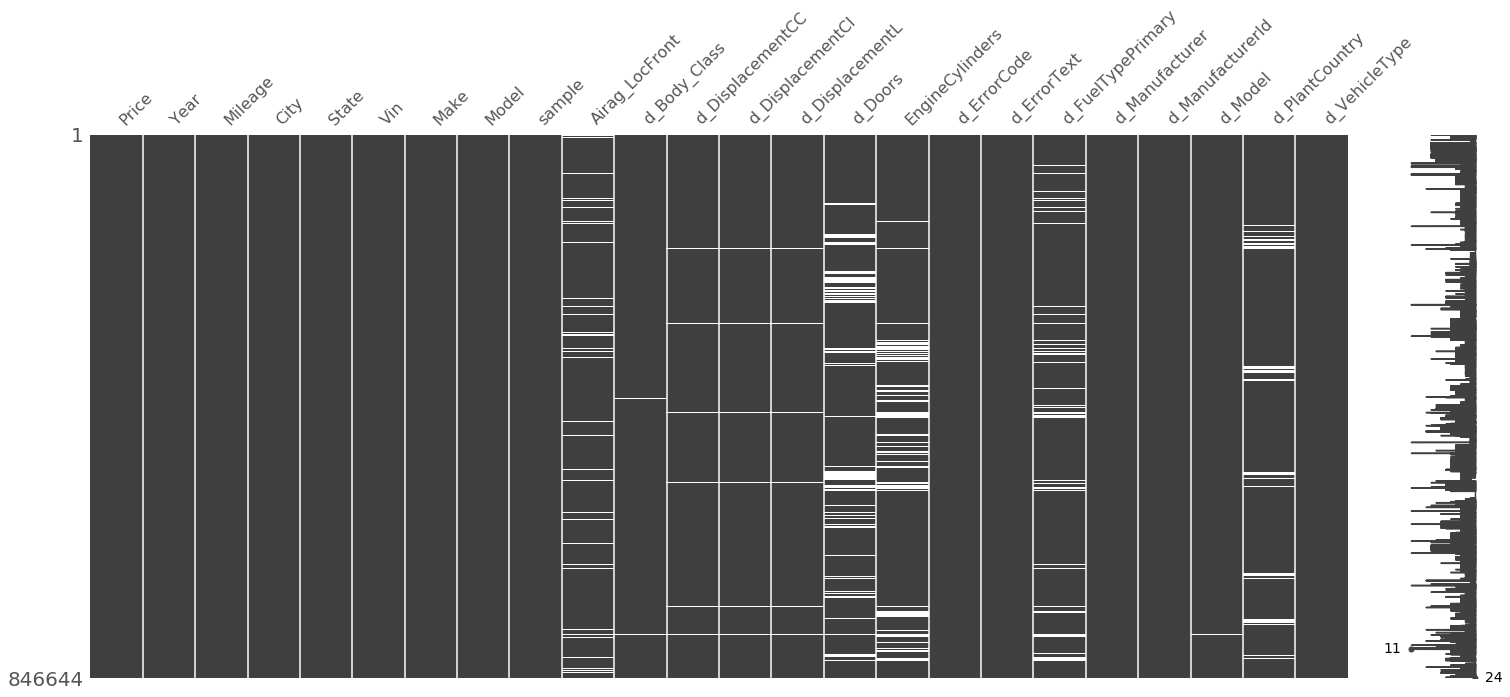

In [21]:
msgno.matrix(df)

# 3. Preproceso

In [22]:
# Librerar Memoria RAM
%xdel df_train
%xdel df_test
%xdel df_data

In [23]:
# Selección de variables para modelos
select_vars = ['Price', 'Model', 'Mileage', 'sample']

In [24]:
# Muestra aleatoria
df_sample = df[select_vars]\
                .sample(sample_size)\
                .reset_index(drop=True)

In [25]:
# Instanciar clase para realizar preproceso
#df_prep = PrepML(df.loc[:, select_vars])
df_prep = PrepML(df_sample)

In [26]:
# Realizamos OneHot Encoder a las columnas categóricas seleccionadas
df_prep.one_hot_encoder(['Model'])

,Price,Mileage,sample,Model_Silverado,Model_F-1504WD,Model_3,Model_Civic,Model_Sierra,Model_Accord,Model_RX,...,Model_ILX5-Speed,Model_GLSGLS,Model_X3xDrive35i,Model_MalibuLS,Model_4,Model_SedonaLX,Model_CTS,Model_C-ClassC250,Model_AcadiaFWD,Model_Impala4dr
0,27988,29242,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000,90000,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32595,53101,train,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23990,55133,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29999,37833,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,13195,88524,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,14754,13222,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,29989,32175,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,20888,8497,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Removemos outliers (opcional)
#df_prep.remove_outliers(['Price', 'Mileage'], multiplier=1.5)

In [28]:
# Estandarizamos variables continuas seleccionadas
df_prep.standard_scaler(['Price', 'Mileage'])

,sample,Model_Silverado,Model_F-1504WD,Model_3,Model_Civic,Model_Sierra,Model_Accord,Model_RX,Model_Super,Model_F-1502WD,...,Model_X3xDrive35i,Model_MalibuLS,Model_4,Model_SedonaLX,Model_CTS,Model_C-ClassC250,Model_AcadiaFWD,Model_Impala4dr,Price,Mileage
0,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555022,-0.594193
1,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.006443,0.928755
2,train,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.954937,0.003852
3,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207972,0.054786
4,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.729589,-0.378853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729098,0.891758
496,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.593767,-0.995747
497,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728721,-0.520675
498,train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061300,-1.114183


In [29]:
# Separar muestras según
X_train, y_train, X_test, y_test = df_prep.to_train_test_samples('sample', 'Price')

Realizado en 0.0s


# 4. Modelamiento 

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

## 4.1 Ridge Regression

In [31]:
# Establecemos parámetros a evaluar en el modelo
ridge_grid = {'alpha': [0, .1, .2],
              'solver': ['sag', 'sparse_cg']}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
ridge_reg = MLModel(model=Ridge(fit_intercept=True))
# Implementación del grid search
ridge_reg.grid_search(X_train,
                      y_train,
                      param_grid=ridge_grid,
                      cv=5)

{'alpha': 0, 'solver': 'sag'}
Realizado en 3.0s


In [32]:
# Métricas
ridge_reg.metrics(X_test, y_test)

mse: 0.599
mae: 0.523
r2: 0.424


{'mse': 0.599, 'mae': 0.523, 'r2': 0.424}

In [34]:
# Instancibest_modelos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
linear2_reg = MLModel(model=LinearRegression(fit_intercept=True))
# Implementación del grid search
linear2_reg.fit(X_train, y_train)

Realizado en 0.0s


In [35]:
linear2_reg.metrics(X_test, y_test)

mse: 1.6709838922503286e+27
mae: 6244549136060.921
r2: -1.605585405864954e+27


{'mse': 1.6709838922503286e+27,
 'mae': 6244549136060.921,
 'r2': -1.605585405864954e+27}

## 4.2 LightGBM

In [36]:
# Establecemos parámetros a evaluar en el modelo
lgb_grid = {'max_depth': [3, 4, 5], 
            'n_estimators': [50, 60, 70],
            'num_leaves': [30, 50, 70]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
lgb_reg = MLModel(model=LGBMRegressor(n_jobs=-1,
                                      random_state=rd_seed))
# Implementación del grid search
lgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=lgb_grid,
                    cv=5)

{'max_depth': 3, 'n_estimators': 50, 'num_leaves': 30}
Realizado en 14.0s


In [37]:
lgb_reg.metrics(X_test, y_test)

mse: 0.808
mae: 0.671
r2: 0.224


{'mse': 0.808, 'mae': 0.671, 'r2': 0.224}

## 4.3 XGBoost

In [39]:
# Establecemos parámetros a evaluar en el modelo
xgb_grid = {'max_depth': [3, 4, 5, 6], 
            'n_estimators': [50, 60, 70]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
xgb_reg = MLModel(model=XGBRegressor(n_jobs=-1,
                                     seed=rd_seed))
# Implementación del grid search
xgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=xgb_grid,
                    cv=5)

[00:51:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 5, 'n_estimators': 70}
Realizado en 5.0s


In [40]:
# Métricas
xgb_reg.metrics(X_test, y_test)

mse: 0.709
mae: 0.613
r2: 0.318


{'mse': 0.709, 'mae': 0.613, 'r2': 0.318}

## 4.4 RandomForest

In [45]:
# Establecemos parámetros a evaluar en el modelo
rf_grid = {'n_estimators': [400, 500], 
           'max_depth': [3, 5, 7], 
           'oob_score': [True]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
rf_reg = MLModel(model=RandomForestRegressor(n_jobs=-1,
                                             random_state=rd_seed))
# Implementación del grid search
rf_reg.grid_search(X_train,
                    y_train,
                    param_grid=rf_grid,
                    cv=5)

{'max_depth': 3, 'n_estimators': 400, 'oob_score': True}
Realizado en 2.0s


In [46]:
rf_reg.metrics(X_test, y_test)

mse: 0.781
mae: 0.647
r2: 0.249


{'mse': 0.781, 'mae': 0.647, 'r2': 0.249}